In [38]:
# Código 9.0:  Bibliotecas e programas %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#                 rode sempre este código antes dos demais

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from sklearn.isotonic import IsotonicRegression



In [ ]:
# Código 9.1: Distribuição de STATUS em cada classe de y_pred_prob / caso REGLOG

kim=pd.read_excel('/content/sample_data/kim_final_reglog.xlsx')

# Dividir o SCORE em 10 classes de mesma frequência
classes, bins = pd.qcut(kim['y_pred_prob'], 10, retbins=True)
# Adiciona as classes com os limites de SCORE
kim['PMP_CLASS'] = pd.cut(kim['y_pred_prob'], bins, include_lowest=True, labels=[f'{bins[i]:.3f} - {bins[i+1]:.3f}' for i in range(len(bins)-1)])
# Calcular a distribuição de STATUS dentro de cada classe de SCORE
distribuicao = kim.groupby('PMP_CLASS')['status_mp'].value_counts(normalize=True).unstack(fill_value=0)

# Mostrar a tabela
distribuicao.columns = ['BP', 'MP']
distribuicao['BP / MP'] = distribuicao['BP'] / distribuicao['MP'].replace(0, 1)  # Substituir 0 por 1 para evitar divisão por zero
print(distribuicao.round(3))

#Criar o gráfico de barras lado a lado
dist = distribuicao[['BP','MP']]
dist.plot(kind='bar', figsize=(10, 6), width=0.8, color=['lightgrey', 'grey'])
plt.title('Distribuição de BP e MP por Classe de pmp', fontsize=14)
plt.xlabel('Classe de pmp', fontsize=12)
plt.ylabel('Frequência Relativa (%)', fontsize=12)
# Ajustar o eixo X
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo X para melhor legibilidade
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

In [ ]:
# Código 9.2: Curvas para cálculo de KS  para REG LOG %%%%%%%%%%%%%%%%%%%%%%%%%%

kim=pd.read_excel('/content/sample_data/kim_final_reglog.xlsx')

# Separamos as probabilidades de acordo com o status (0 e 1)
# Substituindo 'good' por 'status_mp == 0' e 'bad' por 'status_mp == 1'
bad = kim[kim['status_mp'] == 1]  # Clientes com status_mp = 1 (MP - Mau Pagador)
good = kim[kim['status_mp'] == 0] # Clientes com status_mp = 0 (BP - Bom Pagador)
# Ordenar as probabilidades
prob_0_sorted = np.sort(good['y_pred_prob'])
prob_1_sorted = np.sort(bad['y_pred_prob'])
# Calcular a CDF (Função de Distribuição Acumulada)
cdf_0 = np.arange(1, len(prob_0_sorted) + 1) / len(prob_0_sorted)
cdf_1 = np.arange(1, len(prob_1_sorted) + 1) / len(prob_1_sorted)
# Calcular a distância entre as duas CDFs
# Para comparar as CDFs nas mesmas probabilidades, interpolamos os valores de cdf_1 para as probabilidades de prob_0_sorted
cdf_1_interp = np.interp(prob_0_sorted, prob_1_sorted, cdf_1) # Substituindo cdf_bad por cdf_1, bad por prob_1_sorted e good por prob_0_sorted
# Calculando as distâncias
distances = np.abs(cdf_0 - cdf_1_interp)
# Encontrando a maior distância
max_distance = np.max(distances)
max_distance_index = np.argmax(distances)
max_distance_prob = prob_0_sorted[max_distance_index]

# Plotando o gráfico
plt.figure(figsize=(8, 6))
# CDF para o status 0
plt.plot(prob_0_sorted, cdf_0, label='Status BP', color='blue',linestyle='--', lw=2)
# CDF para o status 1
plt.plot(prob_1_sorted, cdf_1, label='Status MP', color='red', lw=2)

# Destacar a maior distância
plt.scatter(max_distance_prob, cdf_0[max_distance_index], color='black',  zorder=5)
plt.scatter(max_distance_prob, cdf_1_interp[max_distance_index], color='black', zorder=5)
plt.text(max_distance_prob, (cdf_0[max_distance_index] + cdf_1_interp[max_distance_index]) / 2,
         f'Máxima Distância: {max_distance:.2f}', color='black', ha='center')

# Configurações do gráfico
plt.xlabel('K=pmp')
plt.ylabel('CDFm(K) e CDFb(K)')
plt.title('Distribuições Acumuladas de Probabilidade - reglog')
plt.legend()
# Adicionar grid pontilhado
plt.grid(True, linestyle=':', color='gray')
plt.show()

# Imprimir a maior distância e o ponto
print("KS para resultados com reglog")
print(f'KS: {max_distance:.3f} na probabilidade {max_distance_prob:.3f}')


In [ ]:
# Código 9.3: Curvas para cálculo de KS  para RF %%%%%%%%%%%%%%%%%%%%%%%%%%

kim=pd.read_excel('/content/sample_data/kim_final_RF.xlsx')

# Separamos as probabilidades de acordo com o status (0 e 1)
# Substituindo 'good' por 'status_mp == 0' e 'bad' por 'status_mp == 1'
bad = kim[kim['status_mp'] == 1]  # Clientes com status_mp = 1 (MP - Mau Pagador)
good = kim[kim['status_mp'] == 0] # Clientes com status_mp = 0 (BP - Bom Pagador)
# Ordenar as probabilidades
prob_0_sorted = np.sort(good['y_pred_prob'])
prob_1_sorted = np.sort(bad['y_pred_prob'])
# Calcular a CDF (Função de Distribuição Acumulada)
cdf_0 = np.arange(1, len(prob_0_sorted) + 1) / len(prob_0_sorted)
cdf_1 = np.arange(1, len(prob_1_sorted) + 1) / len(prob_1_sorted)
# Calcular a distância entre as duas CDFs
# Para comparar as CDFs nas mesmas probabilidades, interpolamos os valores de cdf_1 para as probabilidades de prob_0_sorted
cdf_1_interp = np.interp(prob_0_sorted, prob_1_sorted, cdf_1) # Substituindo cdf_bad por cdf_1, bad por prob_1_sorted e good por prob_0_sorted
# Calculando as distâncias
distances = np.abs(cdf_0 - cdf_1_interp)
# Encontrando a maior distância
max_distance = np.max(distances)
max_distance_index = np.argmax(distances)
max_distance_prob = prob_0_sorted[max_distance_index]

# Plotando o gráfico
plt.figure(figsize=(8, 6))
# CDF para o status 0
plt.plot(prob_0_sorted, cdf_0, label='Status BP', color='blue',linestyle='--', lw=2)
# CDF para o status 1
plt.plot(prob_1_sorted, cdf_1, label='Status MP', color='red', lw=2)

# Destacar a maior distância
plt.scatter(max_distance_prob, cdf_0[max_distance_index], color='black',  zorder=5)
plt.scatter(max_distance_prob, cdf_1_interp[max_distance_index], color='black', zorder=5)
plt.text(max_distance_prob, (cdf_0[max_distance_index] + cdf_1_interp[max_distance_index]) / 2,
         f'Máxima Distância: {max_distance:.2f}', color='black', ha='center')

# Configurações do gráfico
plt.xlabel('K=pmp')
plt.ylabel('CDFm(K) e CDFb(K)')
plt.title('Distribuições Acumuladas de Probabilidade - RF')
plt.legend()
# Adicionar grid pontilhado
plt.grid(True, linestyle=':', color='gray')
plt.show()

# Imprimir a maior distância e o ponto
print("KS para resultados com RF")
print(f'KS: {max_distance:.3f} na probabilidade {max_distance_prob:.3f}')


In [ ]:
# Código 9.4: Curvas para cálculo de KS  para XGBoost %%%%%%%%%%%%%%%%%%%%%%%%%%

kim=pd.read_excel('/content/sample_data/kim_final_xgb.xlsx')

# Separamos as probabilidades de acordo com o status (0 e 1)
# Substituindo 'good' por 'status_mp == 0' e 'bad' por 'status_mp == 1'
bad = kim[kim['status_mp'] == 1]  # Clientes com status_mp = 1 (MP - Mau Pagador)
good = kim[kim['status_mp'] == 0] # Clientes com status_mp = 0 (BP - Bom Pagador)
# Ordenar as probabilidades
prob_0_sorted = np.sort(good['y_pred_prob'])
prob_1_sorted = np.sort(bad['y_pred_prob'])
# Calcular a CDF (Função de Distribuição Acumulada)
cdf_0 = np.arange(1, len(prob_0_sorted) + 1) / len(prob_0_sorted)
cdf_1 = np.arange(1, len(prob_1_sorted) + 1) / len(prob_1_sorted)
# Calcular a distância entre as duas CDFs
# Para comparar as CDFs nas mesmas probabilidades, interpolamos os valores de cdf_1 para as probabilidades de prob_0_sorted
cdf_1_interp = np.interp(prob_0_sorted, prob_1_sorted, cdf_1) # Substituindo cdf_bad por cdf_1, bad por prob_1_sorted e good por prob_0_sorted
# Calculando as distâncias
distances = np.abs(cdf_0 - cdf_1_interp)
# Encontrando a maior distância
max_distance = np.max(distances)
max_distance_index = np.argmax(distances)
max_distance_prob = prob_0_sorted[max_distance_index]

# Plotando o gráfico
plt.figure(figsize=(8, 6))
# CDF para o status 0
plt.plot(prob_0_sorted, cdf_0, label='Status BP', color='blue',linestyle='--', lw=2)
# CDF para o status 1
plt.plot(prob_1_sorted, cdf_1, label='Status MP', color='red', lw=2)

# Destacar a maior distância
plt.scatter(max_distance_prob, cdf_0[max_distance_index], color='black',  zorder=5)
plt.scatter(max_distance_prob, cdf_1_interp[max_distance_index], color='black', zorder=5)
plt.text(max_distance_prob, (cdf_0[max_distance_index] + cdf_1_interp[max_distance_index]) / 2,
         f'Máxima Distância: {max_distance:.2f}', color='black', ha='center')

# Configurações do gráfico
plt.xlabel('K=pmp')
plt.ylabel('CDFm(K) e CDFb(K)')
plt.title('Distribuições Acumuladas de Probabilidade - XGBoost')
plt.legend()
# Adicionar grid pontilhado
plt.grid(True, linestyle=':', color='gray')
plt.show()

# Imprimir a maior distância e o ponto
print("KS para resultados com XGBoost")
print(f'KS: {max_distance:.3f} na probabilidade {max_distance_prob:.3f}')


In [ ]:
#Código 9.5: Curva ROC e AUC  para  REG LOG %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
kim=pd.read_excel('/content/sample_data/kim_final_reglog.xlsx')

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(kim["status_mp"], kim['y_pred_prob'])
# Calcular a AUC (Área sob a Curva)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPr)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPr)')
plt.title('Curva ROC / REG LOG')
plt.legend(loc='lower right')
plt.show()

# Exibir a AUC
print(f'AUROC - caso REGLOG: {roc_auc:.3f}')


In [ ]:
#Código 9.6: Curva ROC e AUC  para  RF %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
kim=pd.read_excel('/content/sample_data/kim_final_RF.xlsx')

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(kim["status_mp"], kim['y_pred_prob'])
# Calcular a AUC (Área sob a Curva)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPr)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPr)')
plt.title('Curva ROC/RF')
plt.legend(loc='lower right')
plt.show()

# Exibir a AUC
print(f'AUROC - caso Random Forest: {roc_auc:.3f}')


In [ ]:
#Código 9.7: Curva ROC e AUC  para  XGBoost %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
kim=pd.read_excel('/content/sample_data/kim_final_xgb.xlsx')

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(kim["status_mp"], kim['y_pred_prob'])
# Calcular a AUC (Área sob a Curva)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPr)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPr)')
plt.title('Curva ROC /XGBoost')
plt.legend(loc='lower right')
plt.show()

# Exibir a AUC
print(f'AUROC - caso XGBoost: {roc_auc:.3f}')


9821


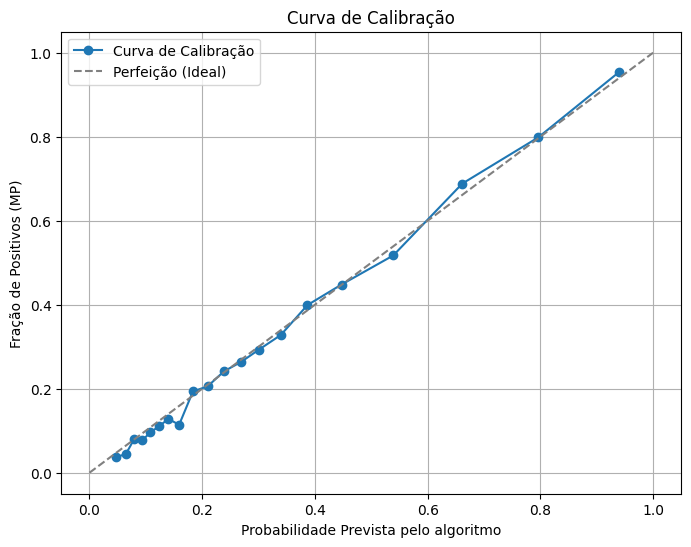

Brier Score do Modelo Original: 0.1450
p-value spiegelhater Modelo Original: 0.0042



Correção de Platt
Optimization terminated successfully.
         Current function value: 0.454432
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              status_mp   No. Observations:                 9821
Model:                          Logit   Df Residuals:                     9819
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 May 2025   Pseudo R-squ.:                  0.2569
Time:                        21:11:09   Log-Likelihood:                -4463.0
converged:                       True   LL-Null:                       -6005.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
c

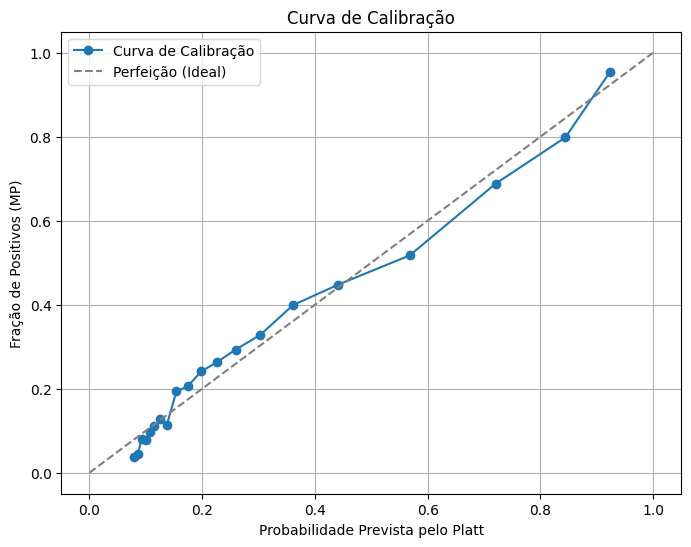




Brier Score do Modelo Calibrado: 0.1459
p-value spiegelhater modelo calibrado com Platt: 0.3989




Calibração com Regressão Isotônica


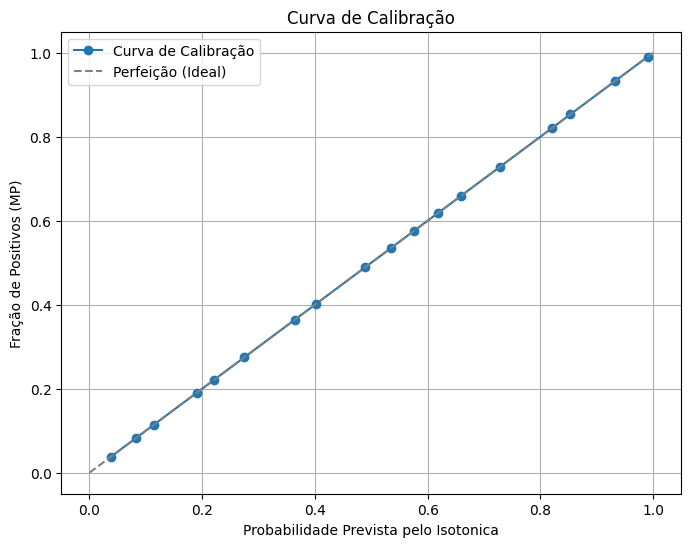

Brier Score do Modelo calibrado isotonica: 0.1438
p-value spiegelhater Modelo calibrado isotonica: 1.0000



0    0.213508
1    0.184321
2    0.768781
3    0.180215
4    0.158147
Name: y_pred_prob, dtype: float64
          0
0  0.210526
1  0.188725
2  0.820896
3  0.188725
4  0.115427


In [46]:
#Código 9.8: teste de Spiegelhalter e correção para XGBoost%%%%%%%%%%%%%%%%%%%%


kim=pd.read_excel('/content/sample_data/kim_final_xgb.xlsx')
y_prob=kim['y_pred_prob']
y_test=kim['status_mp']
print(len(y_prob))
#===============================================================================
# Curva de Calibração
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=20, strategy='quantile')
# Plotando a Curva de Calibração
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Curva de Calibração')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeição (Ideal)', color='gray')
plt.xlabel('Probabilidade Prevista pelo algoritmo')
plt.ylabel('Fração de Positivos (MP)')
plt.title('Curva de Calibração')
plt.legend(loc='best')
plt.grid(True)
plt.show()
#===============================================================================
#teste de spigelhalter
#(https://medium.com/@eligoz/some-notes-on-probabilistic-classifiers-iv-spiegelhalter-z-test-for-calibration-fd6427778ec9)
#cruzei com val.prob do R bate até nas casas decimais

# Calculando o Brier Score para o modelo
bs= brier_score_loss(y_test, y_prob)
print(f'Brier Score do Modelo Original: {bs:.4f}')
EBS=(y_prob*(1-y_prob)).sum()/len(y_prob)
DPBS=np.sqrt(((1-2*y_prob)**2*y_prob*(1-y_prob)).sum())/len(y_prob)
z=(bs-EBS)/DPBS
pval=2*norm.cdf(-abs(z))
print(f"p-value spiegelhater Modelo Original: {pval:.4f}")
print("\n\n")
#===============================================================================
# correção de Platt
print("Correção de Platt")
y_probk = sm.add_constant(y_prob)
model = sm.Logit(y_test, y_probk)
result = model.fit()
print(result.summary())
y_platt = result.predict(y_probk)
#===============================================================================
# Curva de Calibração após platt
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_platt, n_bins=20, strategy="quantile")
# Plotando a Curva de Calibração
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Curva de Calibração')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeição (Ideal)', color='gray')
plt.xlabel('Probabilidade Prevista pelo Platt')
plt.ylabel('Fração de Positivos (MP)')
plt.title('Curva de Calibração')
plt.legend(loc='best')
plt.grid(True)
plt.show()
#===============================================================================
print("\n\n")
# Calculando o Brier Score para o modelo calibrado com Platt
bs= brier_score_loss(y_test, y_platt)
print(f'Brier Score do Modelo Calibrado: {bs:.4f}')
EBS=(y_platt*(1-y_platt)).sum()/len(y_platt)
DPBS=np.sqrt(((1-2*y_platt)**2*y_platt*(1-y_platt)).sum())/len(y_platt)
z=(bs-EBS)/DPBS
pval=2*norm.cdf(-abs(z))
print(f"p-value spiegelhater modelo calibrado com Platt: {pval:.4f}")
#===============================================================================
#calibração com regressao isotônica
print("\n\n\n")
import pandas as pd
import numpy as np
print("Calibração com Regressão Isotônica")

kim=pd.read_excel('/content/sample_data/kim_final_xgb.xlsx')

y_prob=kim['y_pred_prob']
y_test=kim['status_mp']

# Ajustando as probabilidades com Isotonic Regression
iso_reg = IsotonicRegression(out_of_bounds='clip')
y_isotnc= iso_reg.fit_transform(y_prob, y_test)
#===============================================================================
# Curva de Calibração após isotônica
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_isotnc, n_bins=20)
# Plotando a Curva de Calibração
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Curva de Calibração')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeição (Ideal)', color='gray')
plt.xlabel('Probabilidade Prevista pelo Isotonica')
plt.ylabel('Fração de Positivos (MP)')
plt.title('Curva de Calibração')
plt.legend(loc='best')
plt.grid(True)
plt.show()
#===============================================================================
#teste de spigelhalter após isotônica

from scipy.stats import norm
# Calculando o Brier Score para o modelo
bs= brier_score_loss(y_test, y_isotnc)
print(f'Brier Score do Modelo calibrado isotonica: {bs:.4f}')
EBS=(y_isotnc*(1-y_isotnc)).sum()/len(y_isotnc)
DPBS=np.sqrt(((1-2*y_isotnc)**2*y_isotnc*(1-y_isotnc)).sum())/len(y_isotnc)
z=(bs-EBS)/DPBS
pval=2*norm.cdf(-abs(z))
print(f"p-value spiegelhater Modelo calibrado isotonica: {pval:.4f}")
print("\n\n")

y_test=pd.DataFrame(y_prob)
y_isotnc=pd.DataFrame(y_isotnc)
print(y_prob.head(5))
print(y_isotnc.head(5))
